<a href="https://colab.research.google.com/github/SuperYoungCoder/Machine-Learning-with-Python-Tensorflow/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I. Basic regression: Predict fuel efficiency

Initial setup

In [171]:
# This code uses the Keras API

# Use seaborn for pairplot.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip install -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
print(tf.__version__)

2.8.2


1. Get the data

In [273]:
# The Auto MPG dataset - get the data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['LPK', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,LPK,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


2. Clean the data

In [274]:
# The dataset contains categorical values
dataset.isna().sum()

LPK             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [275]:
dataset = dataset.dropna()
# The 'Origin' column is categorical. So as a solution, assiging one-hot encode with pd.get_dummies
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,LPK,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


3. Split the data into training and test sets

In [276]:
train_dataset = dataset.sample(frac=0.6, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset)
print(test_dataset)

      LPK  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
146  28.0          4          90.0        75.0  2125.0          14.5   
282  22.3          4         140.0        88.0  2890.0          17.3   
69   12.0          8         350.0       160.0  4456.0          13.5   
378  38.0          4         105.0        63.0  2125.0          14.7   
331  33.8          4          97.0        67.0  2145.0          18.0   
..    ...        ...           ...         ...     ...           ...   
111  18.0          3          70.0        90.0  2124.0          13.5   
151  31.0          4          79.0        67.0  2000.0          16.0   
159  14.0          8         351.0       148.0  4657.0          13.5   
154  15.0          6         250.0        72.0  3432.0          21.0   
16   18.0          6         199.0        97.0  2774.0          15.5   

     Model Year  Europe  Japan  USA  
146          74       0      0    1  
282          79       0      0    1  
69           72      

4. Inspect the data

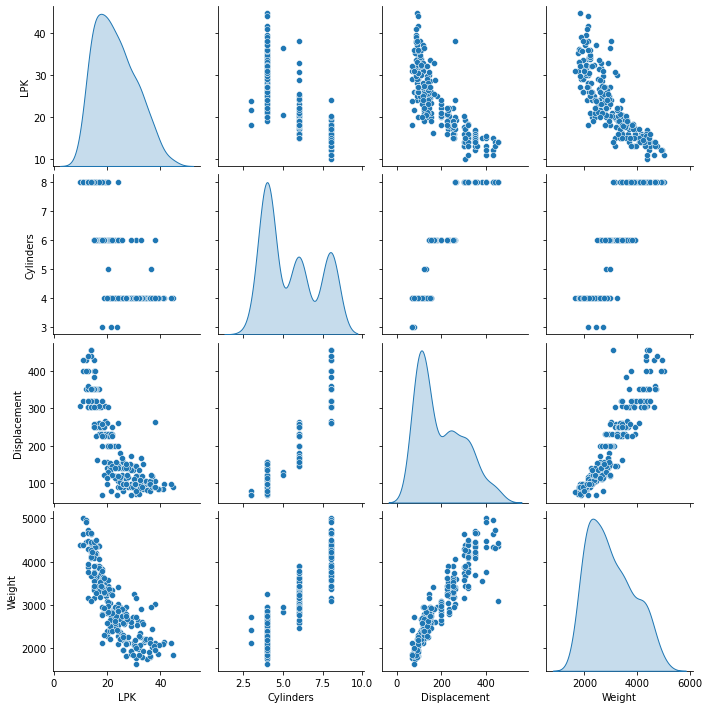

In [277]:
sns.pairplot(train_dataset[['LPK', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [278]:
# Summary Statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LPK,235.0,23.128085,7.623332,10.0,17.0,22.0,28.6,44.6
Cylinders,235.0,5.519149,1.687895,3.0,4.0,6.0,8.0,8.0
Displacement,235.0,196.434043,103.094715,68.0,107.0,155.0,261.0,455.0
Horsepower,235.0,104.957447,37.989291,46.0,76.0,95.0,129.0,225.0
Weight,235.0,2991.165957,839.469059,1649.0,2264.5,2830.0,3609.0,4997.0
Acceleration,235.0,15.529362,2.600039,8.5,14.0,15.5,17.2,24.6
Model Year,235.0,75.910638,3.650971,70.0,73.0,76.0,79.0,82.0
Europe,235.0,0.157447,0.364999,0.0,0.0,0.0,0.0,1.0
Japan,235.0,0.200000,0.400854,0.0,0.0,0.0,0.0,1.0
USA,235.0,0.642553,0.480271,0.0,0.0,1.0,1.0,1.0


5. Split features from labels

In [279]:

train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('LPK')
test_labels = test_features.pop('LPK')

II. Normalization
1. The Normalization layer

In [280]:
# The Normalization layer
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
LPK,23.128085,7.623332
Cylinders,5.519149,1.687895
Displacement,196.434043,103.094715
Horsepower,104.957447,37.989291
Weight,2991.165957,839.469059
Acceleration,15.529362,2.600039
Model Year,75.910638,3.650971
Europe,0.157447,0.364999
Japan,0.200000,0.400854
USA,0.642553,0.480271


In [281]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.519  196.434  104.957 2991.166   15.529   75.911    0.157    0.2
     0.643]]


In [282]:
sample = np.array(train_features[:2])
with np.printoptions(precision=2, suppress=True):
  print('First sample:', sample)
  print()
  print('Normalized:', normalizer(sample).numpy())

First sample: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]
 [   4.   140.    88.  2890.    17.3   79.     0.     0.     1. ]]

Normalized: [[-0.9  -1.03 -0.79 -1.03 -0.4  -0.52 -0.43 -0.5   0.75]
 [-0.9  -0.55 -0.45 -0.12  0.68  0.85 -0.43 -0.5   0.75]]


III. Linear regression
1. Linear regression with one variable

In [294]:
acceleration = np.array(train_features['Acceleration'])

acceleration_normalizer = layers.Normalization(input_shape=[1,], axis=None)
acceleration_normalizer.adapt(acceleration)

# The Keras Sequential model
acceleration_model = tf.keras.Sequential([
    acceleration_normalizer,
    layers.Dense(units=1)
])

acceleration_model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_66 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_90 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [295]:
# Note: this model will predict 'LPK' from 'Acceleration'.
acceleration_model.predict(acceleration[:20])

array([[ 0.275],
       [-0.473],
       [ 0.542],
       [ 0.221],
       [-0.659],
       [-0.446],
       [-0.873],
       [-1.674],
       [-0.259],
       [-0.926],
       [-0.926],
       [ 0.915],
       [-0.126],
       [ 0.408],
       [ 0.168],
       [ 0.301],
       [-0.046],
       [ 0.408],
       [ 0.008],
       [-0.126]], dtype=float32)

In [296]:
acceleration_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [310]:
# Training
%%time
history = acceleration_model.fit(
    train_features['Acceleration'],
    train_labels,
    epochs=200,
    verbose=0,
    validation_split = 0.15)

CPU times: user 6.5 s, sys: 280 ms, total: 6.78 s
Wall time: 6.14 s


In [311]:
# Visualizing the model
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
195,5.578215,5.537760,195
196,5.583256,5.514584,196
197,5.586075,5.516724,197
198,5.584136,5.545339,198
199,5.589368,5.530838,199


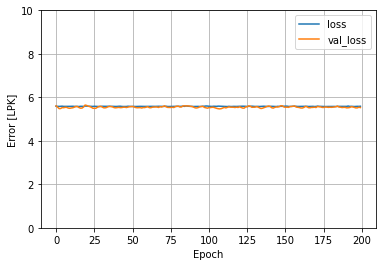

In [314]:
#Plotting the loss on a graph
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [LPK]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

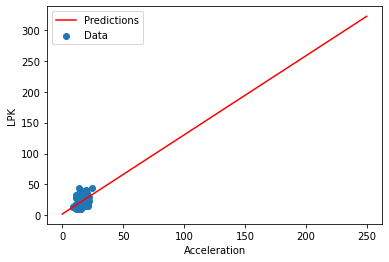

In [315]:
test_results = {}

test_results['acceleration_model'] = acceleration_model.evaluate(
    test_features['Acceleration'],
    test_labels, verbose=0)

x = tf.linspace(0.0, 250, 251)
y = acceleration_model.predict(x)

def plot_acceleration(x, y):
  plt.scatter(train_features['Acceleration'], train_labels, label='Data')
  plt.plot(x, y, color='r', label='Predictions')
  plt.xlabel('Acceleration')
  plt.ylabel('LPK')
  plt.legend()
plot_acceleration(x, y)

2. Linear regression with multiple inputs

In [316]:
# Linear regression with multiple inputs
linear_model = tf.keras.Sequential([
                                    normalizer,
                                    layers.Dense(units=1)
])
linear_model.summary()
linear_model.predict(train_features[:20])

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_63 (Normaliza  (None, 9)                19        
 tion)                                                           
                                                                 
 dense_92 (Dense)            (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


array([[-0.918],
       [-0.431],
       [-1.296],
       [-0.359],
       [ 2.359],
       [-0.378],
       [ 2.482],
       [ 1.884],
       [-0.598],
       [ 1.913],
       [ 0.966],
       [-1.249],
       [-0.801],
       [-1.301],
       [-0.641],
       [ 1.968],
       [ 0.952],
       [-1.104],
       [ 0.691],
       [-0.678]], dtype=float32)

In [318]:
linear_model.layers[1].kernel
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

CPU times: user 6.55 s, sys: 316 ms, total: 6.87 s
Wall time: 10.3 s


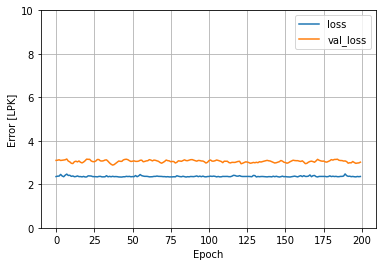

In [321]:
# Training
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=200,
    verbose=0,
    validation_split= 0.15
)
plot_loss(history)

In [323]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)


IV. Regression with a Deep Neural Network

In [324]:
# Regression with a deep neural network
def build_and_compile_model(norm):
  model = keras.Sequential([
                            norm,
                            layers.Dense(64, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

1. Regression using a DNN and a signle input

In [325]:
# Regression using a DNN and a single input: 'Acceleration'
dnn_acceleration_model = build_and_compile_model(acceleration_normalizer)
dnn_acceleration_model.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_66 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_93 (Dense)            (None, 64)                128       
                                                                 
 dense_94 (Dense)            (None, 64)                4160      
                                                                 
 dense_95 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


CPU times: user 6.76 s, sys: 350 ms, total: 7.11 s
Wall time: 6.4 s


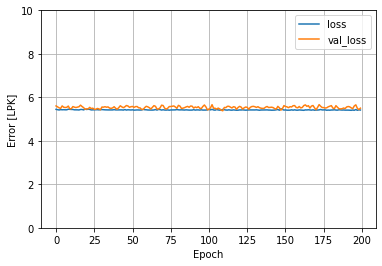

In [334]:
# Training
%%time
history = dnn_acceleration_model.fit(
    train_features['Acceleration'],
    train_labels,
    validation_split=0.15,
    verbose=0, epochs=200)
plot_loss(history)

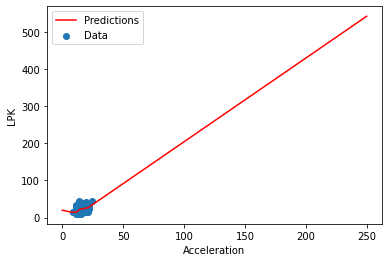

In [341]:
x = tf.linspace(0.0, 250, 251)
y = dnn_acceleration_model.predict(x)
plot_acceleration(x, y)

In [342]:
test_results['dnn_acceleration_model'] = dnn_acceleration_model.evaluate(
    test_features['Acceleration'], test_labels,
    verbose=0)

2. Regression using a DNN and multiple inputs

In [328]:
# Regression using a DNN and multiple inputs
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_63 (Normaliza  (None, 9)                19        
 tion)                                                           
                                                                 
 dense_96 (Dense)            (None, 64)                640       
                                                                 
 dense_97 (Dense)            (None, 64)                4160      
                                                                 
 dense_98 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


CPU times: user 7.54 s, sys: 374 ms, total: 7.91 s
Wall time: 7.08 s


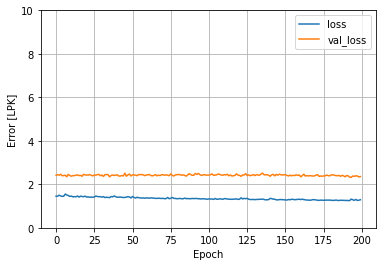

In [336]:
# Training
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.15,
    verbose=0, epochs=200)
plot_loss(history)

In [337]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

V. Performance

In [340]:
# Performance
pd.DataFrame(test_results, index=['Mean absolute error [LPK]'])


,acceleration_model,linear_model,dnn_horsepower_model,dnn_acceleration_model,dnn_model,reloaded
Mean absolute error [LPK],5.892799,2.527344,3.291554,5.643406,2.01135,1.963394


1. Make predictions

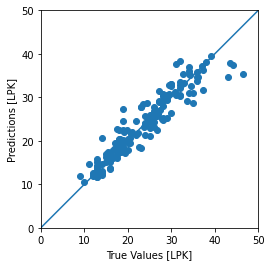

In [333]:
# Make Predictions
test_predictions = dnn_model.predict(test_features).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [LPK]')
plt.ylabel('Predictions [LPK]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

2. Error distribution

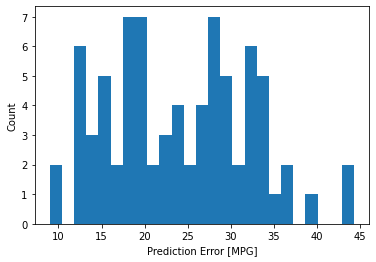

In [81]:
# Error distribution
error = rest_predictions = test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

3. Saving the model

In [82]:
# Saving the model
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


4. Rerunning the model

In [339]:
# Rerunning the model
reloaded = tf.keras.models.load_model('dnn_model')
test_results['reloaded'] = reloaded.evaluate(
	test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [LPK]'])

,acceleration_model,linear_model,dnn_horsepower_model,dnn_acceleration_model,dnn_model,reloaded
Mean absolute error [LPK],5.892799,2.527344,3.291554,5.643406,2.01135,1.963394
